### 1. Load packages

In [11]:
import time

In [2]:
!pip install tinkoff-investments

In [1]:
TOKEN = ''

In [2]:
from tinkoff.invest import Client
from tinkoff.invest.constants import INVEST_GRPC_API_SANDBOX 


with Client(TOKEN, target=INVEST_GRPC_API_SANDBOX ) as client:
    print(client.users.get_accounts())

GetAccountsResponse(accounts=[])


### 2. Load data

In [3]:
import logging
import os

import pandas as pd

from tinkoff.invest import Client, SecurityTradingStatus
from tinkoff.invest.services import InstrumentsService
from tinkoff.invest.utils import quotation_to_decimal



In [5]:
def get_figi(ticker):
    with Client(TOKEN) as client:
        instruments: InstrumentsService = client.instruments
        tickers = []
        for method in ["shares", "bonds", "etfs", "currencies", "futures"]:
            for item in getattr(instruments, method)().instruments:
                tickers.append(
                    {
                        "name": item.name,
                        "ticker": item.ticker,
                        "class_code": item.class_code,
                        "figi": item.figi,
                        "uid": item.uid,
                        "type": method,
                        "min_price_increment": quotation_to_decimal(
                            item.min_price_increment
                        ),
                        "scale": 9 - len(str(item.min_price_increment.nano)) + 1,
                        "lot": item.lot,
                        "trading_status": str(
                            SecurityTradingStatus(item.trading_status).name
                        ),
                        "api_trade_available_flag": item.api_trade_available_flag,
                        "currency": item.currency,
                        "exchange": item.exchange,
                        "buy_available_flag": item.buy_available_flag,
                        "sell_available_flag": item.sell_available_flag,
                        "short_enabled_flag": item.short_enabled_flag,
                        "klong": quotation_to_decimal(item.klong),
                        "kshort": quotation_to_decimal(item.kshort),
                    }
                )

        tickers_df = pd.DataFrame(tickers)

        ticker_df = tickers_df[tickers_df["ticker"] == ticker]
        #return ticker_df
        if ticker_df.empty:
            print("There is no such ticker: %s", ticker)
            return

        figi = ticker_df["figi"].iloc[0]
        return figi

In [6]:
import os
from datetime import timedelta
import datetime

from tqdm import tqdm
import numpy as np

from tinkoff.invest import CandleInterval, Client
from tinkoff.invest.utils import now

def cast_quotation_to_float(quotation):
    #Quotation(units=167, nano=880000000)
    return float(str(quotation.units) + '.' + str(quotation.nano))
    
def get_all_candles(ticker=None, from_=None, to_=None, interval=None):
    
    figi = get_figi(ticker)
    
    with Client(TOKEN) as client:
        
        data = [elem for elem in client.get_all_candles(figi=figi, 
                                      from_=from_-timedelta(hours=3),
                                      to=to_- timedelta(hours=3),
                                     interval=interval
                                    )
               ]

    
    open_ = np.zeros(len(data))
    high = np.zeros(len(data))
    low = np.zeros(len(data))
    close = np.zeros(len(data))
    volume = np.zeros(len(data))
    time = np.zeros(len(data), dtype='O')
    for i, elem in tqdm(enumerate(data)):
        open_[i] = cast_quotation_to_float(elem.open)
        high[i] = cast_quotation_to_float(elem.high)
        low[i] = cast_quotation_to_float(elem.low)
        close[i] = cast_quotation_to_float(elem.close)
        volume[i] = elem.volume
        time[i] = elem.time


    df = pd.DataFrame({'time' : time,
                      'open' : open_,
                      'close' : close,
                      'volume' : volume,
                      'low' : low,
                      'high' : high
                    })
    df['time'] += pd.Timedelta(hours=3)
    return df

In [ ]:
%%time

data = get_all_candles(ticker='GAZP',
                       from_=datetime.datetime(2022, 10, 1, tzinfo=datetime.timezone.utc),
                       to_=datetime.datetime(2024, 11, 20, tzinfo=datetime.timezone.utc),
                       interval=CandleInterval.CANDLE_INTERVAL_5_MIN
                      )

data['ticker'] = 'GAZP'

In [14]:
data

,time,open,close,volume,low,high,ticker
0,2024-10-01 07:00:00+00:00,138.49,138.38,514.0,137.51,138.49,GAZP
1,2024-10-01 07:05:00+00:00,138.16,138.46,1700.0,138.10,138.49,GAZP
2,2024-10-01 07:10:00+00:00,138.29,138.10,314.0,138.90,138.46,GAZP
3,2024-10-01 07:15:00+00:00,138.10,138.22,149.0,138.10,138.25,GAZP
4,2024-10-01 07:20:00+00:00,138.21,138.19,1004.0,138.70,138.28,GAZP
...,...,...,...,...,...,...,...
1769,2024-10-09 23:25:00+00:00,132.42,132.43,2717.0,132.38,132.43,GAZP
1770,2024-10-09 23:30:00+00:00,132.41,132.40,6581.0,132.36,132.43,GAZP
1771,2024-10-09 23:35:00+00:00,132.42,132.41,3618.0,132.36,132.43,GAZP
1772,2024-10-09 23:40:00+00:00,132.41,132.60,30826.0,132.41,132.61,GAZP


In [38]:
!mkdir data

mkdir: data: File exists


In [39]:
!mkdir data/raw

mkdir: data/raw: File exists


In [92]:
!mkdir data/raw/1min

mkdir: data/raw/1min: File exists


In [93]:
!mkdir data/raw/5min

mkdir: data/raw/5min: File exists


In [95]:
!mkdir data/raw/1hour

mkdir: data/raw/1hour: File exists


In [8]:
!mkdir data/raw/1day

mkdir: data/raw/1day: File exists


In [10]:
import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

In [44]:
stocks = [
    'GAZP',
          'SBER',
          'LKOH',
          'MGNT',
          'NVTK',
          'SNGS',
          'GMKN',
          'ROSN',
          'NLMK',
          'TATN',
          'MTSS',
          'ALRS',
          
          'YDEX',
          'CHMF',
          
          'MAGN',
          'TCSG',
          'OZON',
          'RUAL'
          
         ]

for stock in tqdm(stocks):
    data = get_all_candles(ticker=stock,
                       from_=datetime.datetime(2022, 10, 1, tzinfo=datetime.timezone.utc),
                       to_=datetime.datetime(2024, 11, 20, tzinfo=datetime.timezone.utc),
                       interval=CandleInterval.CANDLE_INTERVAL_1_MIN
                      )

    data['ticker'] = stock
    dump_pkl(data, f"./data/raw/1min/{stock}.pkl")
    

  0%|                                                                   | 0/6 [00:00<?, ?it/s]
0it [00:00, ?it/s]
113966it [00:00, 1139647.50it/s]
231559it [00:00, 1160982.56it/s]
347658it [00:00, 1153512.02it/s]
539786it [00:00, 1149106.24it/s]
 17%|█████████▊                                                 | 1/6 [01:37<08:08, 97.77s/it]
0it [00:00, ?it/s]
112084it [00:00, 1120817.02it/s]
224166it [00:00, 1113014.66it/s]
337030it [00:00, 1120118.03it/s]
530271it [00:00, 1123710.64it/s]
 33%|███████████████████▋                                       | 2/6 [03:19<06:39, 99.82s/it]
0it [00:00, ?it/s]
108068it [00:00, 1080660.42it/s]
218961it [00:00, 1097270.07it/s]
329917it [00:00, 1102871.51it/s]
545917it [00:00, 1102342.02it/s]
 50%|█████████████████████████████                             | 3/6 [05:15<05:22, 107.48s/it]
0it [00:00, ?it/s]
110674it [00:00, 1106727.86it/s]
223789it [00:00, 1121081.81it/s]
335898it [00:00, 1119265.60it/s]
481031it [00:00, 1121532.71it/s]
 67%|███████████

In [12]:
#5min
stocks = [
          'GAZP',
          'SBER',
          'LKOH',
          'MGNT',
          'NVTK',
          'SNGS',
          'GMKN',
          'ROSN',
          'NLMK',
          'TATN',
          'MTSS',
          'ALRS',
          
          'YDEX',
          'CHMF',
          
          'MAGN',
          'TCSG',
          'OZON',
          'RUAL'
          
         ]
for stock in tqdm(stocks):
    print(stock)

    
    flag_data1 = False
    while not flag_data1:
        try:
            data1 = get_all_candles(ticker=stock,
                               from_=datetime.datetime(2022, 10, 1, tzinfo=datetime.timezone.utc),
                               to_=datetime.datetime(2023, 10, 1, tzinfo=datetime.timezone.utc),
                               interval=CandleInterval.CANDLE_INTERVAL_5_MIN
                              )
            flag_data1 = True
        except:
            print('Error: flag_data1')
            time.sleep(5)

    
    flag_data2 = False
    while not flag_data2:
        try:            
            data2 = get_all_candles(ticker=stock,
                               from_=datetime.datetime(2023, 10, 1, tzinfo=datetime.timezone.utc),
                               to_=datetime.datetime(2024, 10, 1, tzinfo=datetime.timezone.utc),
                               interval=CandleInterval.CANDLE_INTERVAL_5_MIN
                              )
            flag_data2 = True
        except:
            print('Error: flag_data2')
            time.sleep(5)

    
    flag_data3 = False
    while not flag_data3:
        try:            
            data3 = get_all_candles(ticker=stock,
                               from_=datetime.datetime(2024, 10, 1, tzinfo=datetime.timezone.utc),
                               to_=datetime.datetime(2024, 11, 20, tzinfo=datetime.timezone.utc),
                               interval=CandleInterval.CANDLE_INTERVAL_5_MIN
                              )
            flag_data3 = True
        except:
            print('Error: flag_data3')
            time.sleep(5)


    data = pd.concat([data1, data2, data3])
    data.sort_values(by='time', inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    data['ticker'] = stock
    dump_pkl(data, f"./data/raw/5min/{stock}.pkl")

  0%|                                                    | 0/18 [00:00<?, ?it/s]

GAZP



52680it [00:00, 797602.87it/s]

58429it [00:00, 749480.83it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data3


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data3


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data3


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data3



9875it [00:00, 622632.39it/s]
  6%|██▍                                         | 1/18 [01:16<21:34, 76.14s/it]

SBER



52579it [00:00, 776292.61it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



58435it [00:00, 885798.17it/s]

9881it [00:00, 623723.29it/s]
 11%|████▉                                       | 2/18 [02:40<21:35, 80.94s/it]

LKOH


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



52615it [00:00, 782190.46it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



58367it [00:00, 898566.10it/s]

9798it [00:00, 513338.05it/s]
 17%|███████▎                                    | 3/18 [04:37<24:22, 97.49s/it]

MGNT


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



51261it [00:00, 877969.59it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



55630it [00:00, 859255.57it/s]

9175it [00:00, 610682.04it/s]
 22%|█████████▌                                 | 4/18 [06:37<24:47, 106.26s/it]

NVTK


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



52151it [00:00, 1171176.64it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



57766it [00:00, 899836.46it/s]

9805it [00:00, 608819.53it/s]
 28%|███████████▉                               | 5/18 [08:43<24:35, 113.47s/it]

SNGS


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



47998it [00:00, 655791.66it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



54124it [00:00, 804193.30it/s]

8456it [00:00, 585148.73it/s]
 33%|██████████████▎                            | 6/18 [10:39<22:52, 114.40s/it]

GMKN


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



49697it [00:00, 1125029.42it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



55481it [00:00, 878825.41it/s]

9703it [00:00, 1002965.52it/s]
 39%|████████████████▋                          | 7/18 [12:38<21:12, 115.69s/it]

ROSN


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



52479it [00:00, 746757.95it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



58204it [00:00, 876379.93it/s]

9885it [00:00, 629661.56it/s]
 44%|███████████████████                        | 8/18 [14:36<19:24, 116.43s/it]

NLMK


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



51791it [00:00, 692079.67it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



56975it [00:00, 872750.64it/s]

9691it [00:00, 588830.94it/s]
 50%|█████████████████████▌                     | 9/18 [16:43<17:58, 119.81s/it]

TATN


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



52066it [00:00, 738933.23it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



57937it [00:00, 908658.96it/s]

9812it [00:00, 602775.70it/s]
 56%|███████████████████████▎                  | 10/18 [18:38<15:45, 118.24s/it]

MTSS


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



51284it [00:00, 740062.64it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



57157it [00:00, 1154920.77it/s]

9455it [00:00, 598228.18it/s]
 61%|█████████████████████████▋                | 11/18 [20:36<13:47, 118.17s/it]

ALRS


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



52581it [00:00, 773319.61it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



57761it [00:00, 897894.47it/s]

9727it [00:00, 602549.07it/s]
 67%|████████████████████████████              | 12/18 [22:33<11:47, 117.91s/it]

YDEX


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



52586it [00:00, 1140466.56it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



50851it [00:00, 897839.86it/s]

9832it [00:00, 632568.37it/s]
 72%|██████████████████████████████▎           | 13/18 [24:37<09:58, 119.72s/it]

CHMF


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



52144it [00:00, 714124.56it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



57806it [00:00, 860566.26it/s]

9673it [00:00, 477750.20it/s]
 78%|████████████████████████████████▋         | 14/18 [26:37<07:58, 119.72s/it]

MAGN


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



52476it [00:00, 1136529.47it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



57746it [00:00, 824836.89it/s]

9830it [00:00, 552251.71it/s]
 83%|███████████████████████████████████       | 15/18 [28:39<06:01, 120.41s/it]

TCSG


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



41491it [00:00, 1167896.13it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



49683it [00:00, 841156.57it/s]

9871it [00:00, 568575.67it/s]
 89%|█████████████████████████████████████▎    | 16/18 [30:35<03:58, 119.17s/it]

OZON


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



52579it [00:00, 702965.76it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



58289it [00:00, 1113786.87it/s]

9825it [00:00, 635020.75it/s]
 94%|███████████████████████████████████████▋  | 17/18 [32:38<02:00, 120.44s/it]

RUAL


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



52530it [00:00, 758204.99it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



56779it [00:00, 872974.76it/s]

9285it [00:00, 608844.23it/s]
100%|██████████████████████████████████████████| 18/18 [34:38<00:00, 115.47s/it]


In [13]:
#1hour
for stock in tqdm(stocks):
    flag_data = False
    while not flag_data:
        try:
            data = get_all_candles(ticker=stock,
                       from_=datetime.datetime(2022, 10, 1, tzinfo=datetime.timezone.utc),
                       to_=datetime.datetime(2024, 11, 20, tzinfo=datetime.timezone.utc),
                       interval=CandleInterval.CANDLE_INTERVAL_HOUR
                      )
            flag_data = True
        except:
            print('Error: flag_data')
            time.sleep(5)

    data['ticker'] = stock
    dump_pkl(data, f"./data/raw/1hour/{stock}.pkl")

  0%|                                                    | 0/18 [00:00<?, ?it/s]
10786it [00:00, 488624.23it/s]
  6%|██▍                                         | 1/18 [00:07<02:06,  7.44s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data



10777it [00:00, 518074.66it/s]
 11%|████▉                                       | 2/18 [00:42<06:19, 23.72s/it]
10785it [00:00, 466702.11it/s]
 17%|███████▎                                    | 3/18 [00:49<03:58, 15.87s/it]
10741it [00:00, 1135558.67it/s]
 22%|█████████▊                                  | 4/18 [00:56<02:57, 12.67s/it]
10708it [00:00, 310693.48it/s]
 28%|████████████▏                               | 5/18 [01:03<02:18, 10.66s/it]
10737it [00:00, 485089.37it/s]
 33%|██████████████▋                             | 6/18 [01:10<01:51,  9.27s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data



10685it [00:00, 485906.61it/s]
 39%|█████████████████                           | 7/18 [01:37<02:46, 15.14s/it]
10753it [00:00, 1123965.18it/s]
 44%|███████████████████▌                        | 8/18 [01:44<02:06, 12.61s/it]
10743it [00:00, 360261.99it/s]
 50%|██████████████████████                      | 9/18 [01:52<01:37, 10.88s/it]
10714it [00:00, 343771.21it/s]
 56%|███████████████████████▉                   | 10/18 [01:58<01:17,  9.64s/it]
10741it [00:00, 462835.50it/s]
 61%|██████████████████████████▎                | 11/18 [02:06<01:02,  8.91s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data



10770it [00:00, 431972.44it/s]
 67%|████████████████████████████▋              | 12/18 [02:39<01:38, 16.40s/it]
10110it [00:00, 606219.01it/s]
 72%|███████████████████████████████            | 13/18 [02:45<01:06, 13.35s/it]
10766it [00:00, 934633.37it/s]
 78%|█████████████████████████████████▍         | 14/18 [02:52<00:45, 11.40s/it]
10744it [00:00, 475254.19it/s]
 83%|███████████████████████████████████▊       | 15/18 [02:59<00:29,  9.87s/it]
9096it [00:00, 987712.66it/s]
 89%|██████████████████████████████████████▏    | 16/18 [03:05<00:17,  8.84s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data



10783it [00:00, 519005.53it/s]
 94%|████████████████████████████████████████▌  | 17/18 [03:38<00:16, 16.17s/it]
10744it [00:00, 504982.21it/s]
100%|███████████████████████████████████████████| 18/18 [03:46<00:00, 12.56s/it]


In [15]:
#1day
for stock in tqdm(stocks):
    flag_data = False
    while not flag_data:
        try:
            data = get_all_candles(ticker=stock,
                               from_=datetime.datetime(2022, 10, 1, tzinfo=datetime.timezone.utc),
                               to_=datetime.datetime(2024, 11, 20, tzinfo=datetime.timezone.utc),
                               interval=CandleInterval.CANDLE_INTERVAL_DAY)
            flag_data = True
        except:
            print('Error: flag_data')
            time.sleep(5)

    data['ticker'] = stock
    dump_pkl(data, f"./data/raw/1day/{stock}.pkl")

  0%|                                                    | 0/18 [00:00<?, ?it/s]
545it [00:00, 488334.90it/s]
  6%|██▍                                         | 1/18 [00:01<00:21,  1.25s/it]
545it [00:00, 658001.06it/s]
 11%|████▉                                       | 2/18 [00:02<00:19,  1.25s/it]
545it [00:00, 614653.32it/s]
 17%|███████▎                                    | 3/18 [00:03<00:18,  1.26s/it]
545it [00:00, 508428.75it/s]
 22%|█████████▊                                  | 4/18 [00:05<00:20,  1.43s/it]
545it [00:00, 699692.59it/s]
 28%|████████████▏                               | 5/18 [00:06<00:18,  1.42s/it]
545it [00:00, 693325.96it/s]
 33%|██████████████▋                             | 6/18 [00:08<00:16,  1.36s/it]
541it [00:00, 686571.40it/s]
 39%|█████████████████                           | 7/18 [00:09<00:14,  1.34s/it]
545it [00:00, 642827.81it/s]
 44%|███████████████████▌                        | 8/18 [00:10<00:13,  1.30s/it]
545it [00:00, 581652.84it/s]
 50%|█████

### 3. Посмотрим на объемы торгов во времени

#### 3.1 По минутам

In [107]:
# 1 min

path = './data/raw/1min/NVTK.pkl'
df = load_pkl(path)
df['time'] = df['time'].apply(lambda x: x.tz_convert(None))

df

,time,open,close,volume,low,high,ticker
0,2022-10-03 09:59:00,978.0,978.0,1933.0,978.0,978.0,NVTK
1,2022-10-03 10:00:00,976.4,979.8,11255.0,975.8,982.2,NVTK
2,2022-10-03 10:01:00,979.8,977.0,11999.0,975.2,981.0,NVTK
3,2022-10-03 10:02:00,977.8,978.2,8573.0,976.2,980.0,NVTK
4,2022-10-03 10:03:00,977.8,979.4,6881.0,976.2,980.0,NVTK
...,...,...,...,...,...,...,...
549278,2024-11-19 23:45:00,875.2,875.2,417.0,875.2,875.4,NVTK
549279,2024-11-19 23:46:00,875.4,875.4,1183.0,875.2,875.6,NVTK
549280,2024-11-19 23:47:00,875.2,875.2,222.0,875.2,875.6,NVTK
549281,2024-11-19 23:48:00,875.2,875.8,1933.0,875.2,875.8,NVTK


In [108]:
start = pd.Timestamp('2024-09-14')
end = pd.Timestamp('2024-09-15')

mask = (start <= df['time']) & (df['time'] < end)
mask.sum()

670

In [109]:
df_day= df.loc[mask, :]
df_day = df_day.set_index('time')
df_day

,open,close,volume,low,high,ticker
time,,,,,,
2024-09-14 07:02:00,967.4,967.0,54.0,967.0,967.4,NVTK
2024-09-14 07:03:00,969.0,969.0,5.0,969.0,969.0,NVTK
2024-09-14 07:04:00,967.0,967.0,2.0,967.0,967.0,NVTK
2024-09-14 07:05:00,967.0,968.8,3.0,967.0,968.8,NVTK
2024-09-14 07:06:00,968.6,968.6,3.0,968.6,968.6,NVTK
...,...,...,...,...,...,...
2024-09-14 23:37:00,972.8,972.8,1.0,972.8,972.8,NVTK
2024-09-14 23:39:00,972.8,973.0,54.0,972.8,973.0,NVTK
2024-09-14 23:40:00,973.0,971.0,42.0,971.0,973.0,NVTK


<Axes: xlabel='time'>

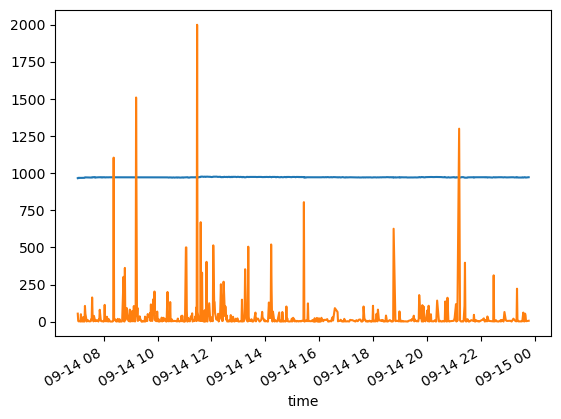

In [110]:
import matplotlib.pyplot as plt

df_day['close'].plot()
df_day['volume'].plot()
#plt.xticks(pd.date_range(pd.Timestamp('2024-11-4'), pd.Timestamp('2024-11-18'), freq='D'))

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_30423/4201550703.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_day[['volume']].reset_index().groupby(pd.Grouper(key='time', freq='H')).volume.sum().plot.bar()


<Axes: xlabel='time'>

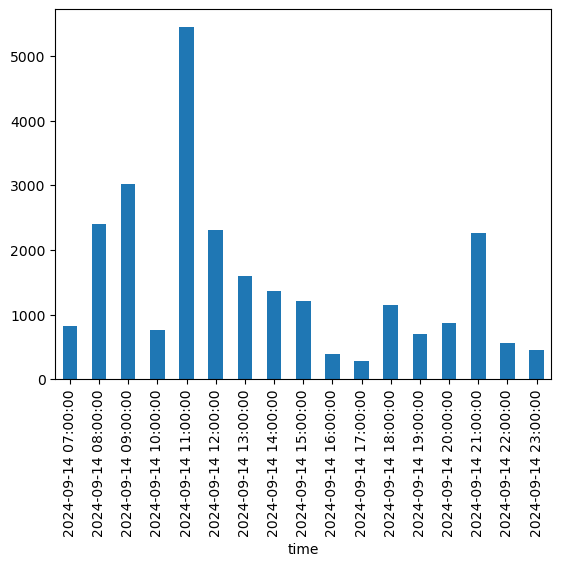

In [111]:
df_day[['volume']].reset_index().groupby(pd.Grouper(key='time', freq='H')).volume.sum().plot.bar()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_30423/2747695137.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_day[['volume']].reset_index().groupby(pd.Grouper(key='time', freq='H')).volume.sum().plot.bar()


<Axes: xlabel='time'>

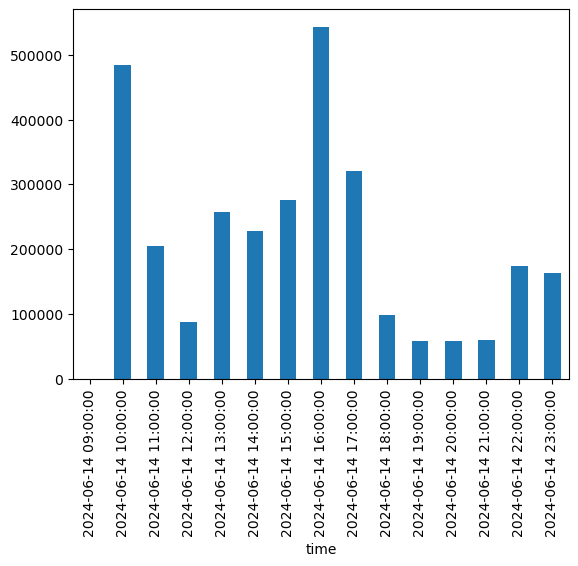

In [115]:
start = pd.Timestamp('2024-06-14')
end = pd.Timestamp('2024-06-15')

mask = (start <= df['time']) & (df['time'] < end)

df_day= df.loc[mask, :]
df_day = df_day.set_index('time')

df_day[['volume']].reset_index().groupby(pd.Grouper(key='time', freq='H')).volume.sum().plot.bar()

In [116]:
#Вывод: обрезать справа не будем, объемы есть

#### 3.1 По дням

In [117]:
path = './data/raw/1day/SBER.pkl'
df = load_pkl(path)
df['time'] = df['time'].apply(lambda x: x.tz_convert(None))

df

,time,open,close,volume,low,high,ticker
0,2022-09-30 03:00:00,111.00,110.21,13356904.0,103.40,113.40,SBER
1,2022-10-03 03:00:00,110.62,114.35,7396096.0,109.00,114.65,SBER
2,2022-10-04 03:00:00,115.60,110.55,8356468.0,110.30,115.50,SBER
3,2022-10-05 03:00:00,110.49,108.51,9041692.0,106.25,110.49,SBER
4,2022-10-06 03:00:00,108.65,108.24,5174148.0,107.57,110.38,SBER
...,...,...,...,...,...,...,...
540,2024-11-13 03:00:00,255.29,254.70,4454002.0,254.50,258.96,SBER
541,2024-11-14 03:00:00,254.26,249.52,4901175.0,248.60,255.92,SBER
542,2024-11-15 03:00:00,249.31,253.43,4420170.0,248.50,254.43,SBER
543,2024-11-18 03:00:00,249.00,248.72,5155991.0,247.30,251.94,SBER


In [118]:
start = pd.Timestamp('2024-10-1')
end = pd.Timestamp('2024-10-31')

mask = (start <= df['time']) & (df['time'] < end)
mask.sum()

22

In [119]:
df_month= df.loc[mask, :]
df_month = df_month.set_index('time')
df_month

,open,close,volume,low,high,ticker
time,,,,,,
2024-10-01 03:00:00,267.60,266.29,5212580.0,264.00,268.68,SBER
2024-10-02 03:00:00,266.10,259.31,4651920.0,258.52,268.00,SBER
2024-10-03 03:00:00,259.31,264.25,5653456.0,257.20,264.49,SBER
2024-10-04 03:00:00,264.96,264.90,2599229.0,262.11,265.44,SBER
2024-10-07 03:00:00,264.25,263.39,2894060.0,261.37,267.00,SBER
2024-10-08 03:00:00,263.00,262.40,1616378.0,261.89,263.80,SBER
2024-10-09 03:00:00,262.42,260.86,2502135.0,259.59,263.80,SBER
2024-10-10 03:00:00,260.88,259.98,1767723.0,258.91,261.64,SBER
2024-10-11 03:00:00,259.80,256.94,2484858.0,256.80,260.70,SBER


<Axes: xlabel='time'>

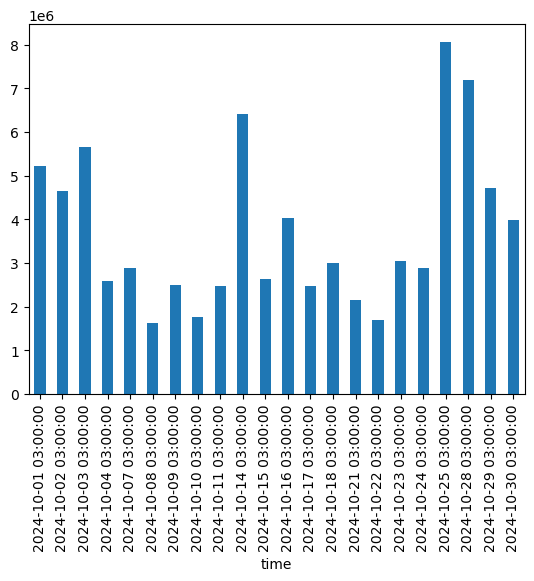

In [121]:
import matplotlib.pyplot as plt

#df_day['close'].plot()
df_month['volume'].plot.bar()
#plt.xticks(pd.date_range(start, end, freq='D'))

In [ ]:
#Выходных нет, это хорошо, так как они внутри тинька идут, а не на биржи

### 4. Preproc data

* Оставляем только будни
* И часы основных торгов - 10:00–23, но на вечерних торгх тоже есть объемы, было бы глупо их не учитывать, поэтому 10:00–24:00

In [122]:
!mkdir data/preproc

mkdir: data/preproc: File exists


In [123]:
!mkdir data/preproc/1min

mkdir: data/preproc/1min: File exists


In [124]:
!mkdir data/preproc/5min

In [125]:
!mkdir data/preproc/1hour

In [126]:
!mkdir data/preproc/1day

In [127]:
def is_business_day(date):
    return bool(len(pd.bdate_range(date, date)))

def preproc(data):
    data['time'] = data['time'].apply(lambda x: x.tz_convert(None))
    
    mask_bd = np.array(data['time'].apply(lambda x: is_business_day(x)))
    data = data.loc[mask_bd, :]

    mask_volume = np.array(datetime.time(10, 0) <= pd.to_datetime(data['time'], format='%H:%M').dt.time)
    data = data.loc[mask_volume, :]

    data.reset_index(drop=True, inplace=True)

    return data
                                         

    

In [128]:
stocks = [
          'GAZP',
          'SBER',
          'LKOH',
          'MGNT',
          'NVTK',
          'SNGS',
          'GMKN',
          'ROSN',
          'NLMK',
          'TATN',
          'MTSS',
          'ALRS',  
          'YDEX',
          'CHMF',
          
          'MAGN',
          'TCSG',
          'OZON',
          'RUAL'  
         ]

for stock in tqdm(stocks):
    data = load_pkl(f"./data/raw/1min/{stock}.pkl")

    data = preproc(data)
    
    dump_pkl(data, f"./data/preproc/1min/{stock}.pkl")

100%|███████████████████████████████████████████| 18/18 [01:56<00:00,  6.47s/it]


In [130]:
#5min
for stock in tqdm(stocks):
    data = load_pkl(f"./data/raw/5min/{stock}.pkl")

    data = preproc(data)
    
    dump_pkl(data, f"./data/preproc/5min/{stock}.pkl")

100%|███████████████████████████████████████████| 18/18 [00:26<00:00,  1.47s/it]


In [131]:
#1hour
for stock in tqdm(stocks):
    data = load_pkl(f"./data/raw/1hour/{stock}.pkl")

    data = preproc(data)
    
    dump_pkl(data, f"./data/preproc/1hour/{stock}.pkl")

100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.56it/s]


In [207]:
def preproc_day_data(data):
    data['time'] = data['time'].apply(lambda x: x.tz_convert(None))
    
    mask_bd = np.array(data['time'].apply(lambda x: is_business_day(x)))
    data = data.loc[mask_bd, :]

    #mask_volume = np.array(datetime.time(10, 0) <= pd.to_datetime(data['time'], format='%H:%M').dt.time)
    #data = data.loc[mask_volume, :]

    data.reset_index(drop=True, inplace=True)

    return data


#1day
for stock in tqdm(stocks):
    data = load_pkl(f"./data/raw/1day/{stock}.pkl")

    data = preproc_day_data(data)
    
    dump_pkl(data, f"./data/preproc/1day/{stock}.pkl")

100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 124.72it/s]


### 5. Анализ на целостность данных

In [133]:
#проверить на заполняемость

#### 5.1 1min

In [135]:
stocks = [
          'GAZP',
          'SBER',
          'LKOH',
          'MGNT',
          'NVTK',
          'SNGS',
          'GMKN',
          'ROSN',
          'NLMK',
          'TATN',
          'MTSS',
          'ALRS',  
          'YDEX',
          'CHMF',
          
          'MAGN',
          'TCSG',
          'OZON',
          'RUAL'  
         ]

for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1min/{stock}.pkl")

    print(stock)
    assert (df['time'].sort_values()  == df['time']).all(), f'{stock} not sorted: {(df['time'].sort_values()  != df['time']).sum()}'
    assert not df['time'].duplicated().any(), f'{stock} duplicated: {df['time'].duplicated().sum()}'
    

 50%|██████████████████████                      | 9/18 [00:00<00:00, 42.82it/s]

GAZP
SBER
LKOH
MGNT
NVTK
SNGS
GMKN
ROSN
NLMK


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 45.94it/s]

TATN
MTSS
ALRS
YDEX
CHMF
MAGN
TCSG
OZON
RUAL


In [136]:
#Нет дублей и данные отсортированы

In [ ]:
#Заполняеимость

In [177]:
stocks = [
          'GAZP',
          'SBER',
          'LKOH',
          'MGNT',
          'NVTK',
          'SNGS',
          'GMKN',
          'ROSN',
          'NLMK',
          'TATN',
          'MTSS',
          'ALRS',  
          'YDEX',
          'CHMF',
          
          'MAGN',
          'TCSG',
          'OZON',
          'RUAL'  
         ]


dfs = []
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1min/{stock}.pkl")
    
    df['diff'] = df['time'].diff() // pd.Timedelta('1 min')
    dfs += [df.copy()]
df = pd.concat(dfs)
df.shape

100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 44.88it/s]


(7847346, 8)

In [186]:
df['diff'].value_counts().sort_values(ascending=False).iloc[:20]

diff
1.0       7702865
2.0         91869
3.0         15336
6.0         10439
15.0         7893
611.0        7621
4.0          4317
3491.0       1873
5.0          1641
16.0         1271
7.0           396
17.0          373
8.0           229
9.0           153
18.0          139
19.0          101
10.0           93
612.0          88
901.0          65
11.0           62
Name: count, dtype: int64

<Axes: xlabel='diff'>

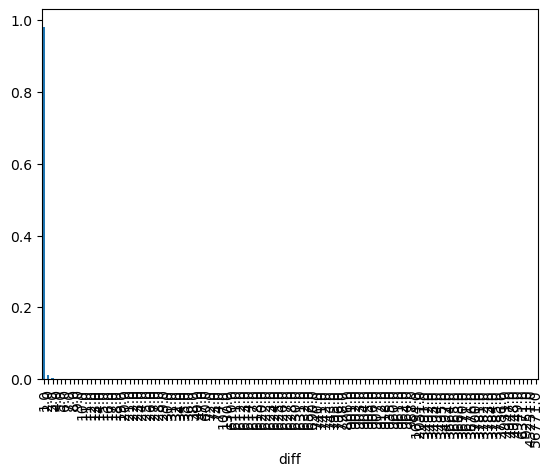

In [190]:
df['diff'].value_counts(normalize=True).sort_index().plot.bar()

In [161]:
threshold = 2
(df['diff'] < 2).mean(), (df['diff'] < 3).mean(), (df['diff'] < 15).mean()

(0.9815885523589759, 0.9932955676989392, 0.9974721389881369)

In [162]:
#Отличные результаты (тут еще смена дня не учтена и выходные)

#### 5.2 5min

In [191]:
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/5min/{stock}.pkl")

    print(stock)
    assert (df['time'].sort_values()  == df['time']).all(), f'{stock} not sorted: {(df['time'].sort_values()  != df['time']).sum()}'
    assert not df['time'].duplicated().any(), f'{stock} duplicated: {df['time'].duplicated().sum()}'
    

100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 168.65it/s]

GAZP
SBER
LKOH
MGNT
NVTK
SNGS
GMKN
ROSN
NLMK
TATN
MTSS
ALRS
YDEX
CHMF
MAGN
TCSG
OZON
RUAL


In [192]:
#Нет дублей и данные отсортированы

In [193]:
#Заполняемость

In [194]:
dfs = []
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/5min/{stock}.pkl")
    
    df['diff'] = df['time'].diff() // pd.Timedelta('5 min')
    dfs += [df.copy()]
df = pd.concat(dfs)
df.shape

100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 168.06it/s]


(1607835, 8)

<Axes: xlabel='diff'>

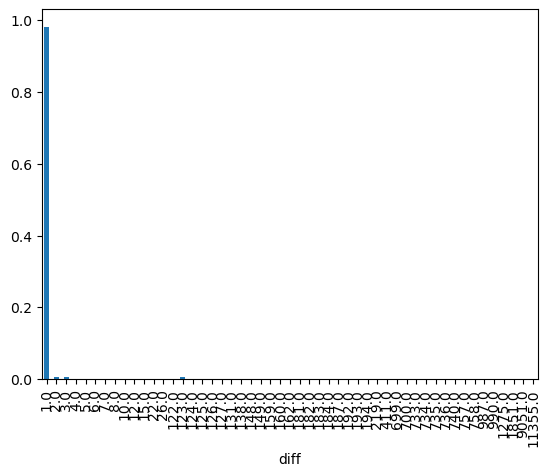

In [195]:
df['diff'].value_counts(normalize=True).sort_index().plot.bar()

In [170]:
threshold = 2
(df['diff'] < 2).mean(), (df['diff'] < 3).mean(), (df['diff'] < 12).mean()

(0.9811056482785858, 0.9876212422294576, 0.9937804563279192)

In [ ]:
#Отлично (тут еще смена дня не учтена и выходные)

#### 5.3 1hour

In [196]:
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")

    print(stock)
    assert (df['time'].sort_values()  == df['time']).all(), f'{stock} not sorted: {(df['time'].sort_values()  != df['time']).sum()}'
    assert not df['time'].duplicated().any(), f'{stock} duplicated: {df['time'].duplicated().sum()}'
    

100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 525.36it/s]

GAZP
SBER
LKOH
MGNT
NVTK
SNGS
GMKN
ROSN
NLMK
TATN
MTSS
ALRS
YDEX
CHMF
MAGN
TCSG
OZON
RUAL


In [197]:
#Нет дублей и данные отсортированы

In [198]:
#Заполняемость

In [199]:
dfs = []
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")
    
    df['diff'] = df['time'].diff() // pd.Timedelta('1 hour')
    dfs += [df.copy()]
df = pd.concat(dfs)
df.shape

100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 1211.82it/s]


(138247, 8)

<Axes: xlabel='diff'>

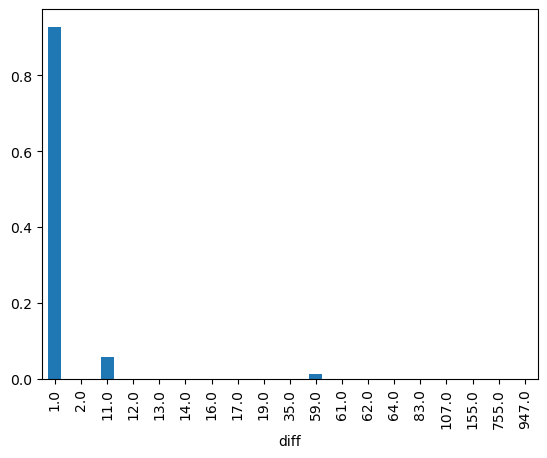

In [200]:
df['diff'].value_counts(normalize=True).sort_index().plot.bar()

In [201]:
threshold = 2
((df['diff'] < 2) | (df['diff'] == 11) | (df['diff'] == 59)).mean()

0.9979095387241677

In [202]:
#Отлично (не все выходные еще учтены)

#### 5.4 1day

In [203]:
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1day/{stock}.pkl")

    print(stock)
    assert (df['time'].sort_values()  == df['time']).all(), f'{stock} not sorted: {(df['time'].sort_values()  != df['time']).sum()}'
    assert not df['time'].duplicated().any(), f'{stock} duplicated: {df['time'].duplicated().sum()}'
    

100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 1013.51it/s]

GAZP
SBER
LKOH
MGNT
NVTK
SNGS
GMKN
ROSN
NLMK
TATN
MTSS
ALRS
YDEX
CHMF
MAGN
TCSG
OZON
RUAL


In [204]:
#Нет дублей и данные отсортированы

In [205]:
#Заполняемость

In [208]:
dfs = []
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1day/{stock}.pkl")
    
    df['diff'] = df['time'].diff() // pd.Timedelta('24 hours')
    dfs += [df.copy()]
df = pd.concat(dfs)
df.shape

100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 973.50it/s]


(9724, 8)

<Axes: xlabel='diff'>

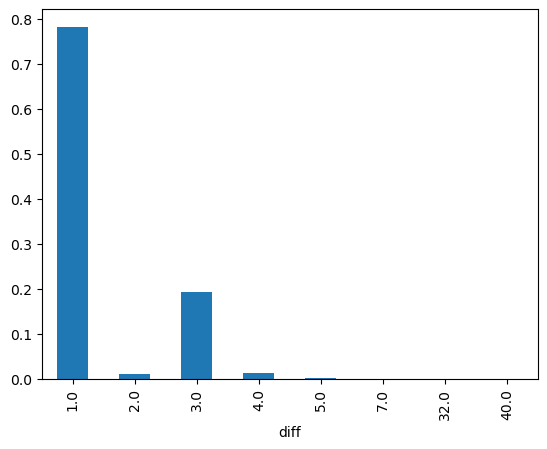

In [209]:
df['diff'].value_counts(normalize=True).sort_index().plot.bar()

In [212]:
threshold = 2
(df['diff'] < 4).mean(), (df['diff'] < 5).mean()

(0.9832373508844097, 0.9959893048128342)

In [213]:
#Отлично

In [216]:
0.687*0.994 + 0.313*1.014

1.0002600000000001